In [1]:
import numpy as np
import trace_gen as tg
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
from scipy import stats
import matplotlib.ticker as ticker
import scipy.stats as ss

# Set the seaborn default color palette
colors = sns.color_palette("deep")

In [2]:
def parse_trace(file, start_row, num_rows):
    file_path = f'/mnt/sda/alibaba_block_traces_2020/{file}.txt'
    
    # Print file path for debugging
    print(f"Reading file: {file_path}")
    
    # Try to load the data
    try:
        trace = np.loadtxt(file_path, skiprows=start_row, max_rows=num_rows, dtype=np.int64)
    except Exception as e:
        print(f"Error reading the file: {e}")
        raise
    
    # Print the shape of the trace array
    print(f"Shape of trace array: {trace.shape}")
    
    # Check if trace is 2D
    if trace.ndim != 2 or trace.shape[1] < 2:
        raise ValueError(f"Expected 2D array with at least 2 columns, but got shape {trace.shape}")
    
    trace[:, 0] += 4095
    trace = tg.squash(tg.unroll(trace // 4096))
    return trace

def plot_hit_rate2(c, hr, irm_recon_hr, ird_recon_hr, title):
    palette = sns.color_palette("husl", 8)
    plt.plot(c, hr, '-', linewidth=3, label=f'Real trace', color=colors[0])
    plt.plot(c, irm_recon_hr, '--', linewidth=4, alpha=0.8, label='IRM reconstruction', color=colors[1])
    plt.plot(c, ird_recon_hr, '--', linewidth=4, alpha=0.8, label='IRD reconstruction', color=colors[2])
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    plt.xlabel('Cache sizes', fontsize=18)
    plt.ylabel('Hit rates', fontsize=18)
    plt.title(f'{title}', fontsize=18)
    plt.grid()
    plt.legend(fontsize=16)
    plt.show()

def process_trace_b(trace_name):
    c = np.loadtxt(f'../data/recon/{trace_name}_c.txt', dtype=np.int32)
    hr_w = np.loadtxt(f'../data/recon/{trace_name}_real_lru_hr.txt', dtype=np.float32)
    hr_recon_ird = np.loadtxt(f'../data/recon/{trace_name}_ird_recon_lru_hr.txt', dtype=np.float32)
    hr_recon_irm = np.loadtxt(f'../data/recon/{trace_name}_irm_recon_lru_hr.txt', dtype=np.float32)
    plot_hit_rate2(c, hr_w, hr_recon_irm, hr_recon_ird, trace_name)

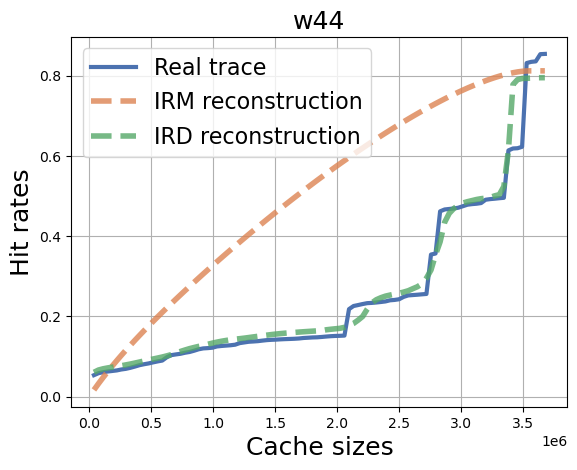

In [3]:
process_trace_b('w44')

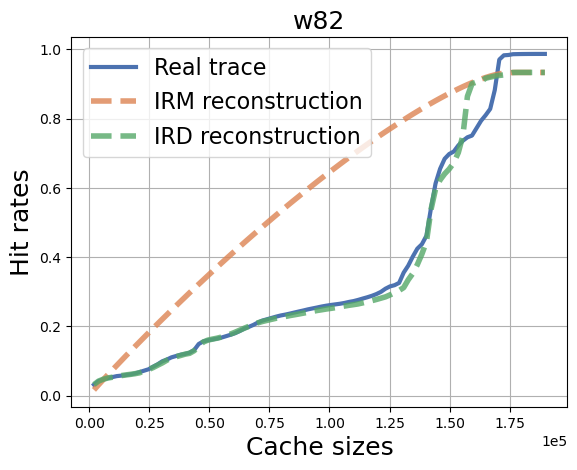

In [4]:
process_trace_b('w82')

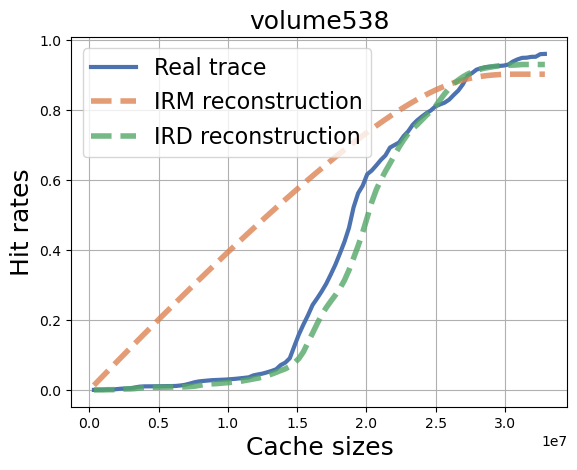

In [5]:
c_v538 = np.loadtxt(f'../data/recon/volume538_c.txt', dtype=np.int32)
hr_v538 = np.loadtxt(f'../data/recon/volume538_real_lru_hr.txt', dtype=np.float32)
hr_recon_ird_v538 = np.loadtxt(f'../data/recon/volume538_ird_recon_lru_hr.txt', dtype=np.float32)
hr_recon_irm_v538 = np.loadtxt(f'../data/recon/volume538_irm_recon_lru_hr.txt', dtype=np.float32)
plot_hit_rate2(c_v538, hr_v538, hr_recon_irm_v538, hr_recon_ird_v538, 'volume538')

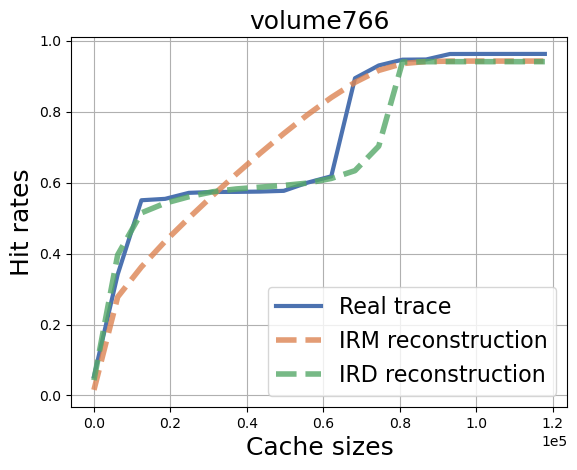

In [9]:

c_v766 = np.loadtxt(f'../data/recon/v766_c.txt', dtype=np.int32)
hr_v766_ird = np.loadtxt(f'../data/recon/v766_ird_recon_lru_hr.txt', dtype=np.float32)
hr_v766_irm = np.loadtxt(f'../data/recon/v766_irm_recon_lru_hr.txt', dtype=np.float32)
hr_v766 = np.loadtxt(f'../data/recon/v766_real_lru_hr.txt', dtype=np.float32)
plot_hit_rate2(c_v766, hr_v766, hr_v766_irm, hr_v766_ird, 'volume766')


In [59]:
def calculate_lru_hr(trace):
    M = len(set(trace))
    c = np.arange(M // 100, M, M // 100)
    hr_lru = [tg.sim_lru(_c, trace) for _c in c]
    return c, hr_lru

def mrc_compute(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_lru = [tg.sim_lru(int(_c), trace, raw=True) for _c in c]
    return c, hr_lru

def ird_separate_plot(trace, is_irm, c, hr_lru, name, g_name='$g$', f_name='$f$'):   
    irds = tg.iad(trace)
    irds = irds[irds > -1]
    irm_trace = trace[is_irm == True]
    ird_trace = trace[is_irm == False]
    print(f'IRM: {len(irm_trace)}, IRD: {len(ird_trace)}')
    if (len(irm_trace)) != 0:
        irm_irds = tg.iad(irm_trace)
        irm_irds = irm_irds[irm_irds > -1]
    else:
        irm_irds = []
    if (len(ird_trace)) != 0:
        ird_irds = tg.iad(ird_trace)
        ird_irds = ird_irds[ird_irds > -1]
    else:
        ird_irds = []

    # plot one lru curve in the middle and two ird distributions on both sides
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    axs[1].hist(irm_irds, bins=50, density=True, color='blue', alpha=0.5, edgecolor='black', label=g_name)
    axs[1].set_xlabel('IRD', fontsize=24)
    axs[1].set_ylabel('PDF', fontsize=24)
    axs[1].set_title('Independent IRD Distribution', fontsize=24)
    axs[1].legend(fontsize=24)

    axs[0].plot(c, hr_lru, '-+', label=name)
    axs[0].set_xlabel('Cache size (C)', fontsize=24)
    axs[0].set_ylabel('Hit rate', fontsize=24)
    axs[0].legend(fontsize=24)
    axs[0].set_title('LRU MRC', fontsize=24)
 
    axs[2].hist(ird_irds, bins=50, density=True, color='red', alpha=0.5, edgecolor='black', label=f_name)
    axs[2].set_xlabel('IRD', fontsize=24)
    axs[2].set_ylabel('PDF', fontsize=24)
    axs[2].set_title('Dependent IRD Distribution', fontsize=24)
    axs[2].legend(fontsize=24)

    axs[3].hist(irds, bins=50, density=True, color='green', alpha=0.5, edgecolor='black')
    axs[3].set_xlabel('IRD', fontsize=24)
    axs[3].set_ylabel('PDF', fontsize=24)
    axs[3].set_title('Merged IRD Distribution', fontsize=24)

    for ax in axs:
        ax.tick_params(axis='both',  labelsize=18)
        ax.ticklabel_format(style='scientific', axis='both', scilimits=(0, 0))
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
        ax.xaxis.get_major_formatter().set_scientific(True)
        ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
        ax.yaxis.get_offset_text().set_fontsize(18)
        ax.xaxis.get_offset_text().set_fontsize(18)

    plt.tight_layout()
    plt.show() 

IRM: 99910, IRD: 900090


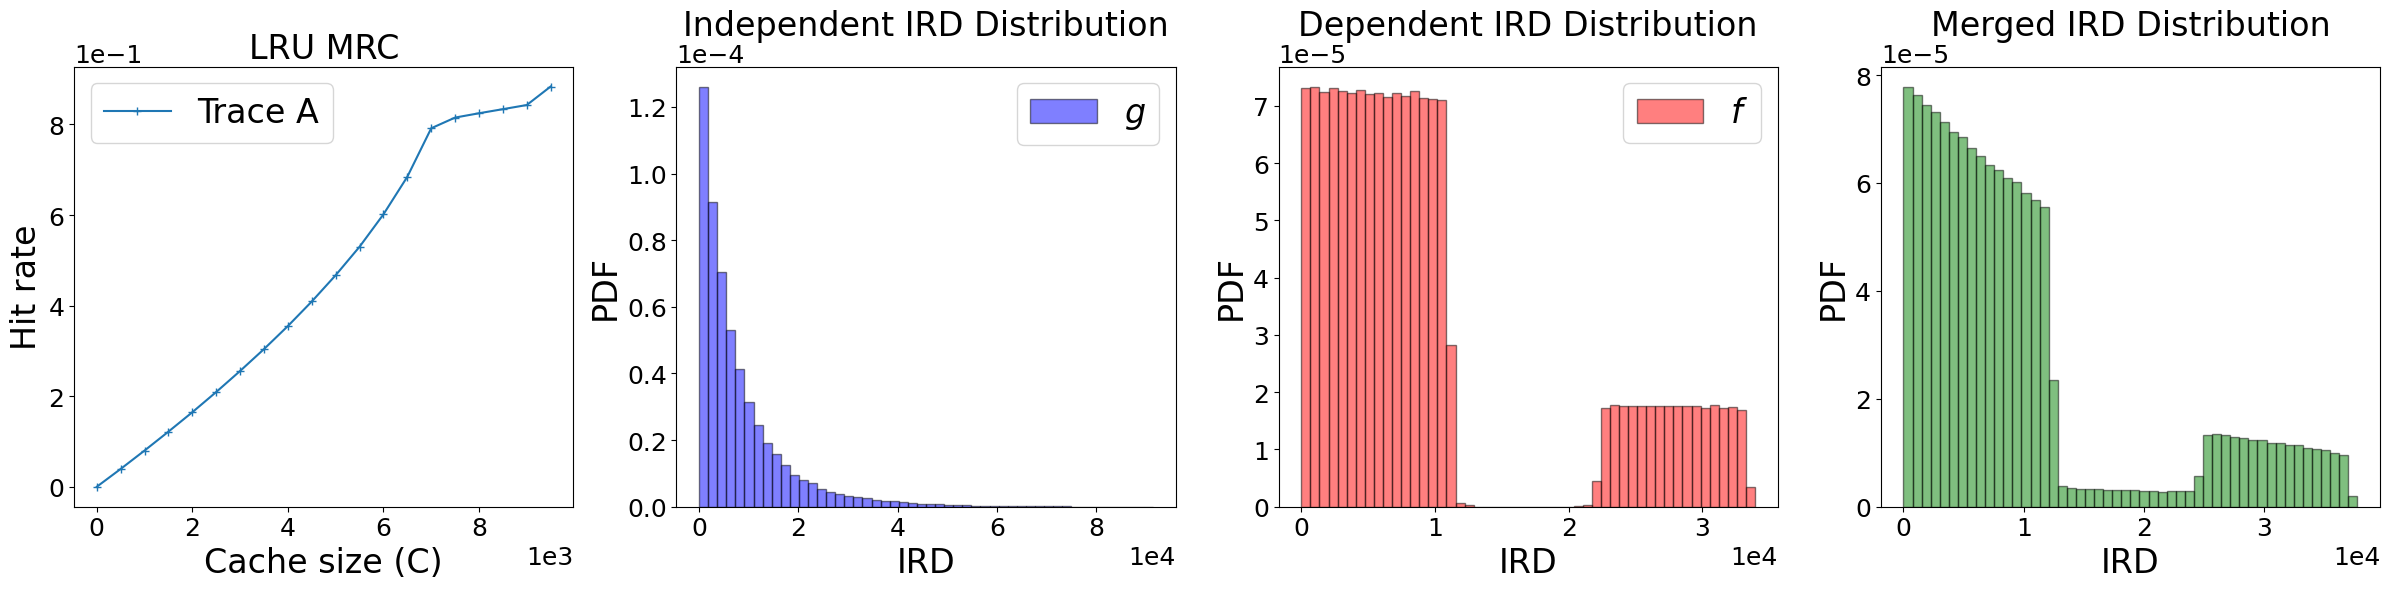

In [60]:
ta = np.loadtxt('./traces/trace_a.txt', dtype=int)
ia = np.loadtxt('./traces/is_irm_a.txt', dtype=int)
ca, hra = mrc_compute(ta)
ird_separate_plot(ta, ia,  ca, hra, 'Trace A')

IRM: 99742, IRD: 900258


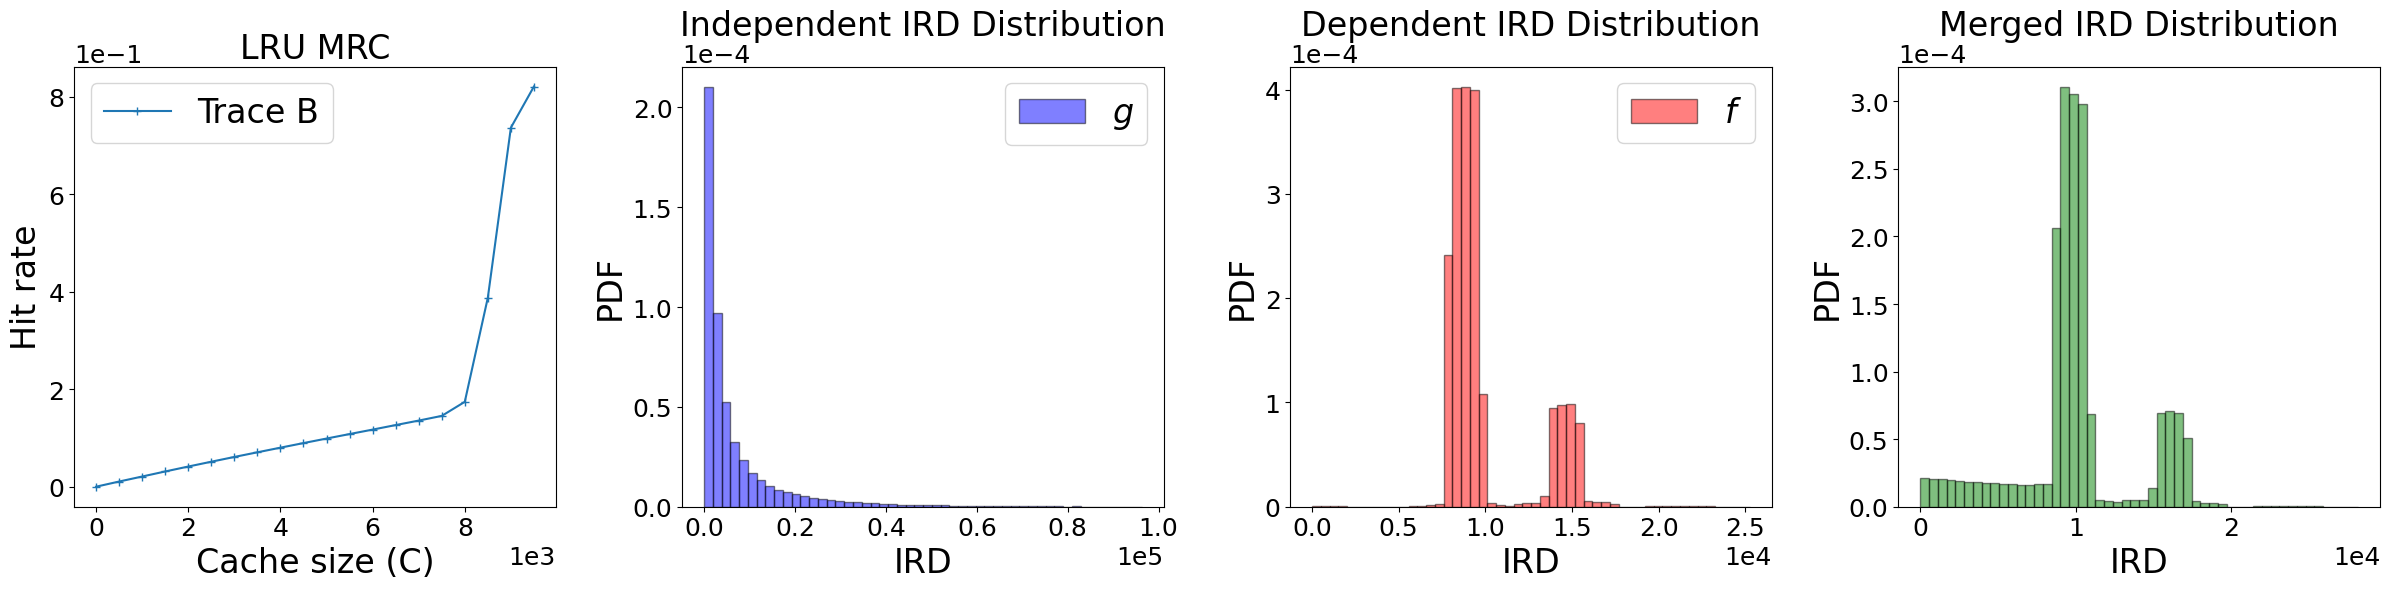

In [61]:
tb = np.loadtxt('./traces/trace_b.txt', dtype=int)
ib = np.loadtxt('./traces/is_irm_b.txt', dtype=int)
cb, hrb = mrc_compute(tb)
ird_separate_plot(tb, ib,  cb, hrb, 'Trace B')

In [6]:
def mrc_ird_compute(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K//2)
    hr_lru = [tg.sim_lru(int(_c), trace, raw=True) for _c in c]
    irds = tg.iad(trace)
    irds = irds[irds > -1]
    # np.savetxt(f'/home/yirongwn/data/LRU/{name}_lru_hr.txt', hr_lru, fmt='%f')
    # np.savetxt(f'/home/yirongwn/data/LRU/{name}_c.txt', c, fmt='%d')
    # np.savetxt(f'/home/yirongwn/data/LRU/{name}_irds.txt', irds, fmt='%d')
    
    return c, hr_lru, irds

def norm(data):
    return (data - data.min()) / (data.max() - data.min())

def mrc_ird_plot(name, c, hr_lru, irds):
    palette = sns.color_palette("husl", 8)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
    
    # Plot for LRU MRC
    axs[0].plot(c, hr_lru, '-', label=f'{name}', linewidth=2, color=palette[0])
    axs[0].set_xlabel('Cache size (C)', fontsize=26)
    axs[0].set_ylabel('Hit rate', fontsize=26)
    axs[0].legend(loc='best', fontsize=26)
    axs[0].xaxis.set_major_formatter(ticker.ScalarFormatter())
    axs[0].xaxis.get_major_formatter().set_scientific(True)
    axs[0].xaxis.get_major_formatter().set_powerlimits((-1, 1))
    axs[0].set_title('LRU MRC', fontsize=26)

    # Adjust tick label size for this axis
    axs[0].tick_params(axis='both', labelsize=14)  # Adjusting the tick label size

    # Plot for IRD Distribution
    axs[1].hist(norm(irds), bins=20, log=True, alpha=0.5, color=palette[4], edgecolor='black')
    axs[1].set_xlabel('Normalized IRDs', fontsize=26)
    axs[1].set_ylabel('Frequency', fontsize=26)
    axs[1].set_title('IRD Distribution', fontsize=26)

    # Adjust tick label size for this axis
    axs[1].tick_params(axis='both', labelsize=14)  # Adjusting the tick label size

    plt.tight_layout()
    plt.show()


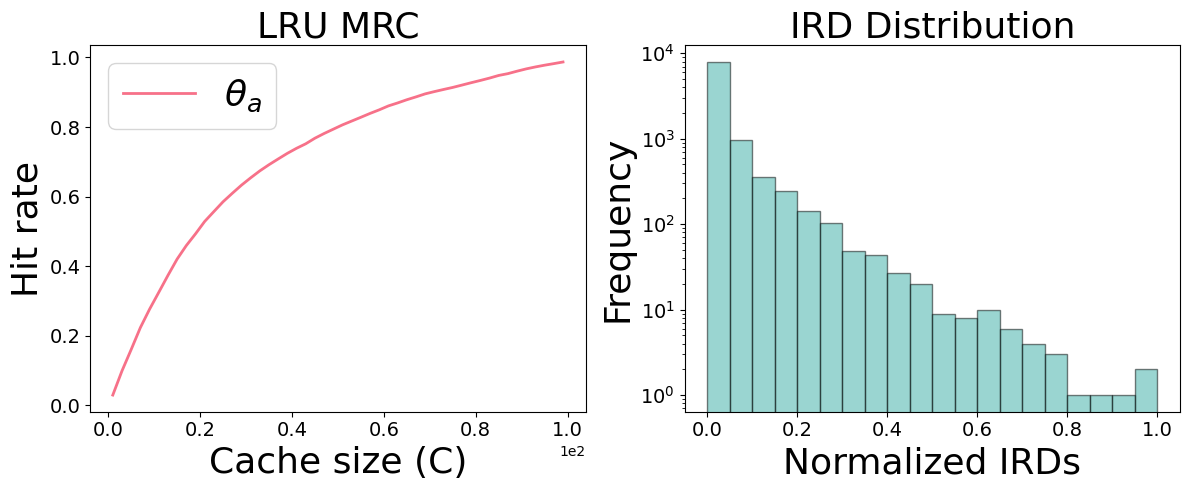

In [7]:
g = tg.TraceGenerator(100, 10000)
t7= g.gen_from_pdf(g.pdf_b, 1.0)
mrc_ird_plot('$\\theta_a$', *mrc_ird_compute(t7))

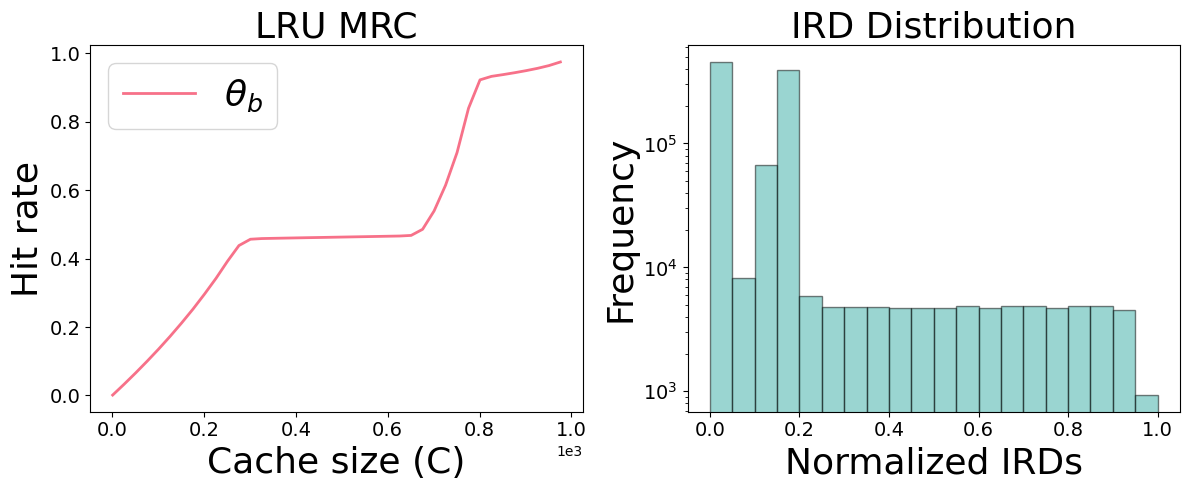

In [8]:
g = tg.TraceGenerator(1000, 1000000)
tb = g.gen_from_pdf(g.pdf_b, 0.0)
mrc_ird_plot('$\\theta_b$', *mrc_ird_compute(tb))

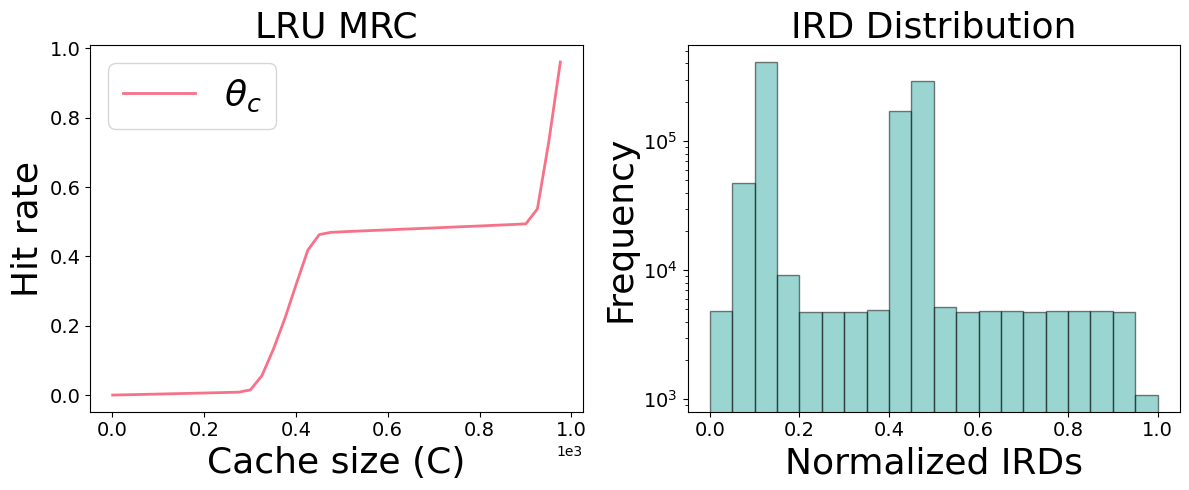

In [9]:
tc = g.gen_from_pdf(g.pdf_c, 0.0)
mrc_ird_plot('$\\theta_c$', *mrc_ird_compute(tc))

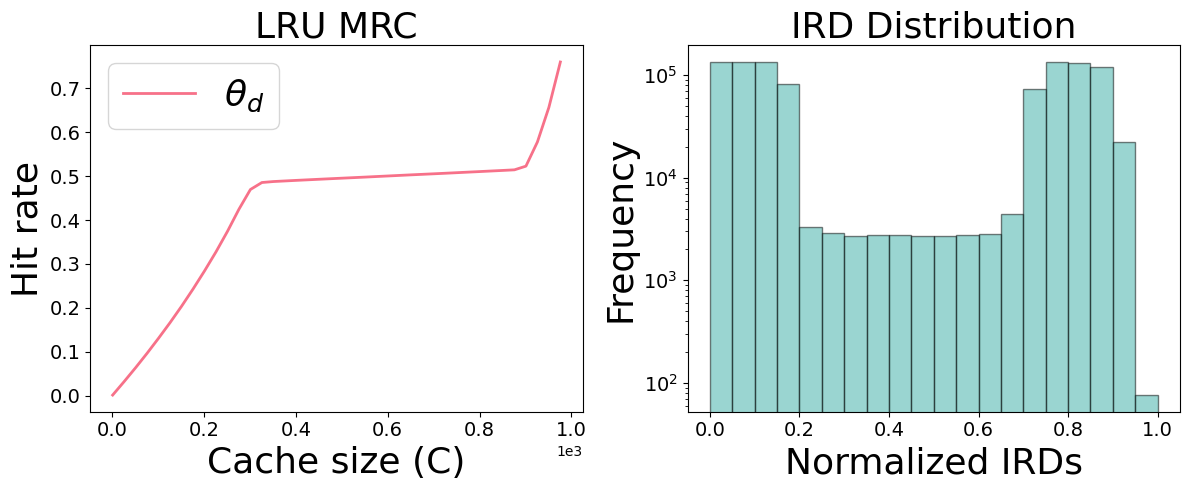

In [10]:
td = g.gen_from_pdf(g.pdf_d, 0.0)
mrc_ird_plot('$\\theta_d$', *mrc_ird_compute(td))

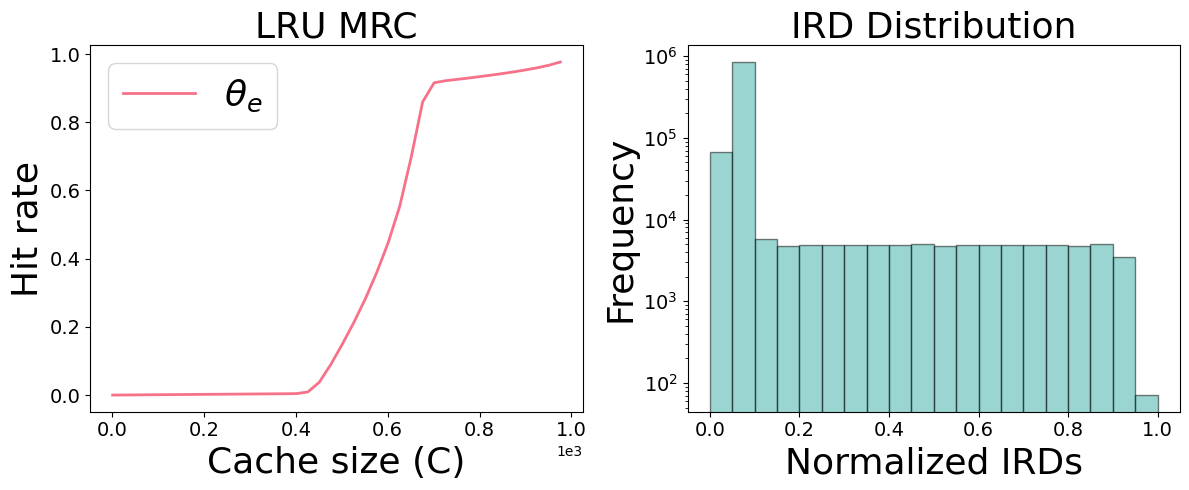

In [11]:
te = g.gen_from_pdf(g.pdf_e, 0.0)
mrc_ird_plot('$\\theta_e$', *mrc_ird_compute(te))

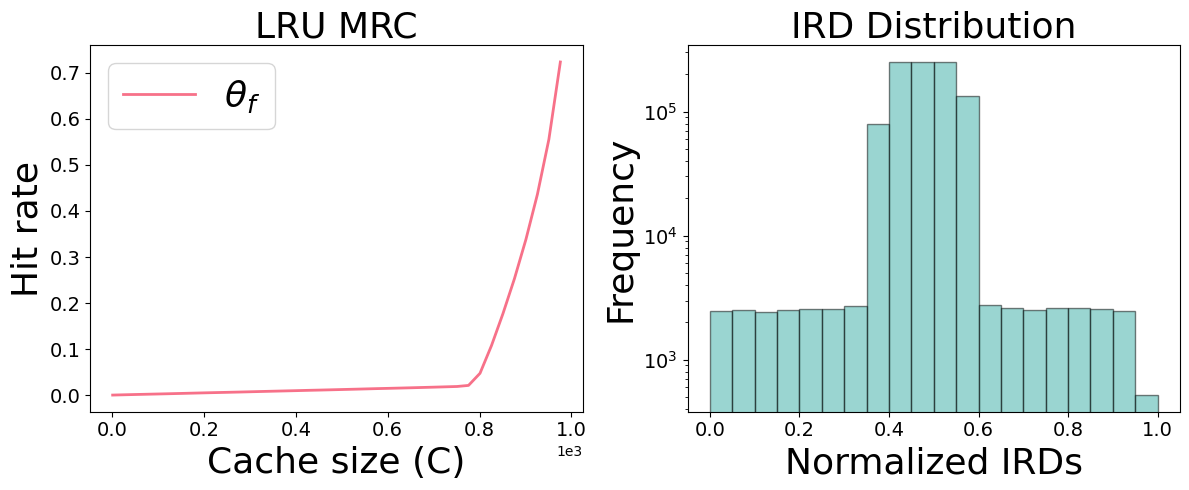

In [12]:
t_f = g.gen_from_pdf(g.pdf_f, p_irm=0.0)
mrc_ird_plot('$\\theta_f$', *mrc_ird_compute(t_f))

In [54]:
import pandas as pd
import seaborn as sns

def norm(data):
    return (data - data.min()) / (data.max() - data.min())

def ird_separate_plots(traces, is_irm_pairs, cs, hr_lrus):
    irm_data = []
    ird_data = []
    merged_ird_data = []
    # labels = ['t0', 't1', 't2', 't3']
    labels = ['t7', 't8', 't9', 't10', 't11']
    # labels = ['t4', 't5', 't6']
    # frac = ['$P_{IRM} = 0.1$', '$P_{IRM} = 0.1$ ', '$P_{IRM} = 0.1$  ', '$P_{IRM} = 0.1$   ', '$P_{IRM} = 0.1$    ', '$P_{IRM} = 0.1$     ']
    # frac = ['$P_{IRM} = 0.9$', '$P_{IRM} = 0.9$ ', '$P_{IRM} = 0.9$  ']
    frac = ['$P_{IRM} = 0.1$', '$P_{IRM} = 0.3$', '$P_{IRM} = 0.5$', '$P_{IRM} = 0.7$', '$P_{IRM} = 0.9$']
    irm_types = ['$g$ = Zipf(1.2)', '$g$ = Zipf(1.2) ', '$g$ = Zipf(1.2)  ', '$g$ = Zipf(1.2)   ', '$g$ = Zipf(1.2)    ', '$g$ = Zipf(1.2)     ']
    # irm_types = ['$g$ = Zipf(1.2)', '$g$ = Pareto(2.5, 1)', '$g$ = Normal(M/2, M/6)']
    # ird_types = ['$f(w_1), w_1 = \{0.9, 0.05, 0.05\}$', '$f(w_2), w_2 = \{0.05, 0.9, 0.05\}$', '$f(w_3), w_3 = \{0.05, 0.05, 0.9\}$', '$f(x;x_0 = 0, \lambda=0.01)$', '$f(x;x_0 = 1/50, \lambda=0.01)$', '$f(x;x_0 = 1/10, \lambda=0.01)$']
    # ird_types = ['$f = \hat{f}_b$', '$f = \hat{f}_c$', '$f = \hat{f}_d$', '$f = \hat{f}_e$'] 
    # ird_types = ['$f = \hat{f}_f$', '$f = \hat{f}_f$ ', '$f = \hat{f}_f$  ']
    # ird_types = ['$f(x;x_0 = 0, \lambda=0.01)$', '$f(x;x_0 = 1/50, \lambda=0.01)$', '$f(x;x_0 = 1/10, \lambda=0.01)$']
 
    ird_types = ['$f = \hat{f_g}$', '$f = \hat{f_g}$ ', '$f = \hat{f_g}$  ', '$f = \hat{f_g}$   ', '$f = \hat{f_g}$    ']
    
    line_widths = [3, 3, 3, 3, 3, 3]
    alphas = [1, 0.7, 0.7, 0.5, 0.5, 1]
    markers = ['', '+', '', '+', '', '+']

    for i, (trace, is_irm) in enumerate(zip(traces, is_irm_pairs)):
        irds = tg.iad(trace)
        irds = irds[irds > -1]
        irm_trace = trace[is_irm == True]
        ird_trace = trace[is_irm == False]
        print(f'IRM: {len(irm_trace)}, IRD: {len(ird_trace)}')

        if len(irm_trace) != 0:
            irm_irds = tg.iad(irm_trace)
            irm_irds = irm_irds[irm_irds > -1]
        else:
            irm_irds = np.array([])

        if len(ird_trace) != 0:
            ird_irds = tg.iad(ird_trace)
            ird_irds = ird_irds[ird_irds > -1]
        else:
            ird_irds = np.array([])

        irm_irds = irm_irds[~np.isnan(irm_irds) & ~np.isinf(irm_irds)]
        ird_irds = ird_irds[~np.isnan(ird_irds) & ~np.isinf(ird_irds)]
        irds = irds[~np.isnan(irds) & ~np.isinf(irds)]

        irm_data.append(pd.DataFrame({'IRD': norm(irm_irds), 'Type': irm_types[i], 'Trace': labels[i]}))
        ird_data.append(pd.DataFrame({'IRD': norm(ird_irds), 'Type': ird_types[i], 'Trace': labels[i]}))
        merged_ird_data.append(pd.DataFrame({'IRD': norm(irds), 'Type': frac[i], 'Trace': labels[i]}))

    irm_data = pd.concat(irm_data)
    ird_data = pd.concat(ird_data)
    merged_ird_data = pd.concat(merged_ird_data)

    fig, axs = plt.subplots(1, 4, figsize=(24, 6))

    for i, (c, hr_lru) in enumerate(zip(cs, hr_lrus)):
        hr_lru = np.array(hr_lru)
        c = norm(c)
        axs[0].plot(c, hr_lru, '-', alpha=alphas[i], marker=markers[i], linewidth=line_widths[i], label=labels[i])
    axs[0].set_xlabel('Cache size (C)', fontsize=24)
    axs[0].set_ylabel('Hit rate', fontsize=24)
    axs[0].set_title('LRU MRC', fontsize=24)
    axs[0].legend(fontsize=16)
    axs[0].tick_params(axis='both', labelsize=14) 
    sns.violinplot(ax=axs[1], data=irm_data, y='Trace', x='IRD', hue='Type', split=False, bw_adjust=.2, palette="pastel", native_scale=True)
    axs[1].set_title('Independent arrivals', fontsize=24)
    axs[1].set_ylabel('Trace', fontsize=24)
    axs[1].set_xlabel('IRD PDF', fontsize=24)
    axs[1].tick_params(axis='both', labelsize=14) 
    sns.violinplot(ax=axs[2], data=ird_data, y='Trace', x='IRD', hue='Type', split=False, bw_adjust=.2, palette="pastel", native_scale=True)
    axs[2].set_title('Dependent arrivals', fontsize=24)
    axs[2].set_ylabel('Trace', fontsize=24)
    axs[2].set_xlabel('IRD PDF', fontsize=24)
    axs[2].tick_params(axis='both', labelsize=14) 
    sns.violinplot(ax=axs[3], data=merged_ird_data, y='Trace', x='IRD', hue='Type', split=False, bw_adjust=.2, palette="pastel", native_scale=True)
    axs[3].set_title('Merged arrivals', fontsize=24)
    axs[3].set_ylabel('Trace', fontsize=24)
    axs[3].set_xlabel('IRD PDF', fontsize=24)
    axs[3].tick_params(axis='both', labelsize=14) 

    for ax in axs:
        ax.ticklabel_format(style='scientific', axis='x', scilimits=(0, 0))
        ax.tick_params(axis='both',  labelsize=20)
    plt.tight_layout()

    # Adjust the legends for axs[1], axs[2], and axs[3]
    for ax in [axs[1], axs[2]]:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles, labels=labels, loc='upper right', fontsize=20)

    # Adjust the legend for axs[3] to be at the bottom right
    handles, labels = axs[3].get_legend_handles_labels()
    axs[3].legend(handles=handles, labels=labels, loc='upper right', fontsize=20)

    plt.tight_layout()
    plt.show()



In [44]:
t0 = np.loadtxt('traces/trace0.txt', dtype=int)
i0 = np.loadtxt('traces/is_irm0.txt', dtype=bool)
c0 = np.loadtxt('traces/c0.txt', dtype=int)
hr0 = np.loadtxt('traces/lru_hr0.txt', dtype=float)
t1 = np.loadtxt('traces/trace1.txt', dtype=int)
t2 = np.loadtxt('traces/trace2.txt', dtype=int)
t3 = np.loadtxt('traces/trace3.txt', dtype=int)
i1 = np.loadtxt('traces/is_irm1.txt', dtype=bool)
i2 = np.loadtxt('traces/is_irm2.txt', dtype=bool)
i3 = np.loadtxt('traces/is_irm3.txt', dtype=bool)
c1 = np.loadtxt('traces/c1.txt', dtype=int)
c2 = np.loadtxt('traces/c2.txt', dtype=int)
c3 = np.loadtxt('traces/c3.txt', dtype=int)
hr1 = np.loadtxt('traces/lru_hr1.txt', dtype=float)
hr2 = np.loadtxt('traces/lru_hr2.txt', dtype=float)
hr3 = np.loadtxt('traces/lru_hr3.txt', dtype=float)
t4 = np.loadtxt('traces/trace4.txt', dtype=int)
t5 = np.loadtxt('traces/trace5.txt', dtype=int)
t6 = np.loadtxt('traces/trace6.txt', dtype=int)
i4 = np.loadtxt('traces/is_irm4.txt', dtype=bool)
i5 = np.loadtxt('traces/is_irm5.txt', dtype=bool)
i6 = np.loadtxt('traces/is_irm6.txt', dtype=bool)
c4 = np.loadtxt('traces/c4.txt', dtype=int)
c5 = np.loadtxt('traces/c5.txt', dtype=int)
c6 = np.loadtxt('traces/c6.txt', dtype=int)
hr4 = np.loadtxt('traces/lru_hr4.txt', dtype=float)
hr5 = np.loadtxt('traces/lru_hr5.txt', dtype=float)
hr6 = np.loadtxt('traces/lru_hr6.txt', dtype=float)
t7 = np.loadtxt('traces/trace7.txt', dtype=int)
t8 = np.loadtxt('traces/trace8.txt', dtype=int)
t9 = np.loadtxt('traces/trace9.txt', dtype=int)
t10 = np.loadtxt('traces/trace10.txt', dtype=int)
t11 = np.loadtxt('traces/trace11.txt', dtype=int)
i7 = np.loadtxt('traces/is_irm7.txt', dtype=bool)
i8 = np.loadtxt('traces/is_irm8.txt', dtype=bool)
i9 = np.loadtxt('traces/is_irm9.txt', dtype=bool)
i10 = np.loadtxt('traces/is_irm10.txt', dtype=bool)
i11 = np.loadtxt('traces/is_irm11.txt', dtype=bool)
c7 = np.loadtxt('traces/c7.txt', dtype=int)
c8 = np.loadtxt('traces/c8.txt', dtype=int)
c9 = np.loadtxt('traces/c9.txt', dtype=int)
c10 = np.loadtxt('traces/c10.txt', dtype=int)
c11 = np.loadtxt('traces/c11.txt', dtype=int)
hr7 = np.loadtxt('traces/lru_hr7.txt', dtype=float)
hr8 = np.loadtxt('traces/lru_hr8.txt', dtype=float)
hr9 = np.loadtxt('traces/lru_hr9.txt', dtype=float)
hr10 = np.loadtxt('traces/lru_hr10.txt', dtype=float)
hr11 = np.loadtxt('traces/lru_hr11.txt', dtype=float)


IRM: 99623, IRD: 900377
IRM: 299176, IRD: 700824
IRM: 500373, IRD: 499627
IRM: 698274, IRD: 301726
IRM: 900502, IRD: 99498


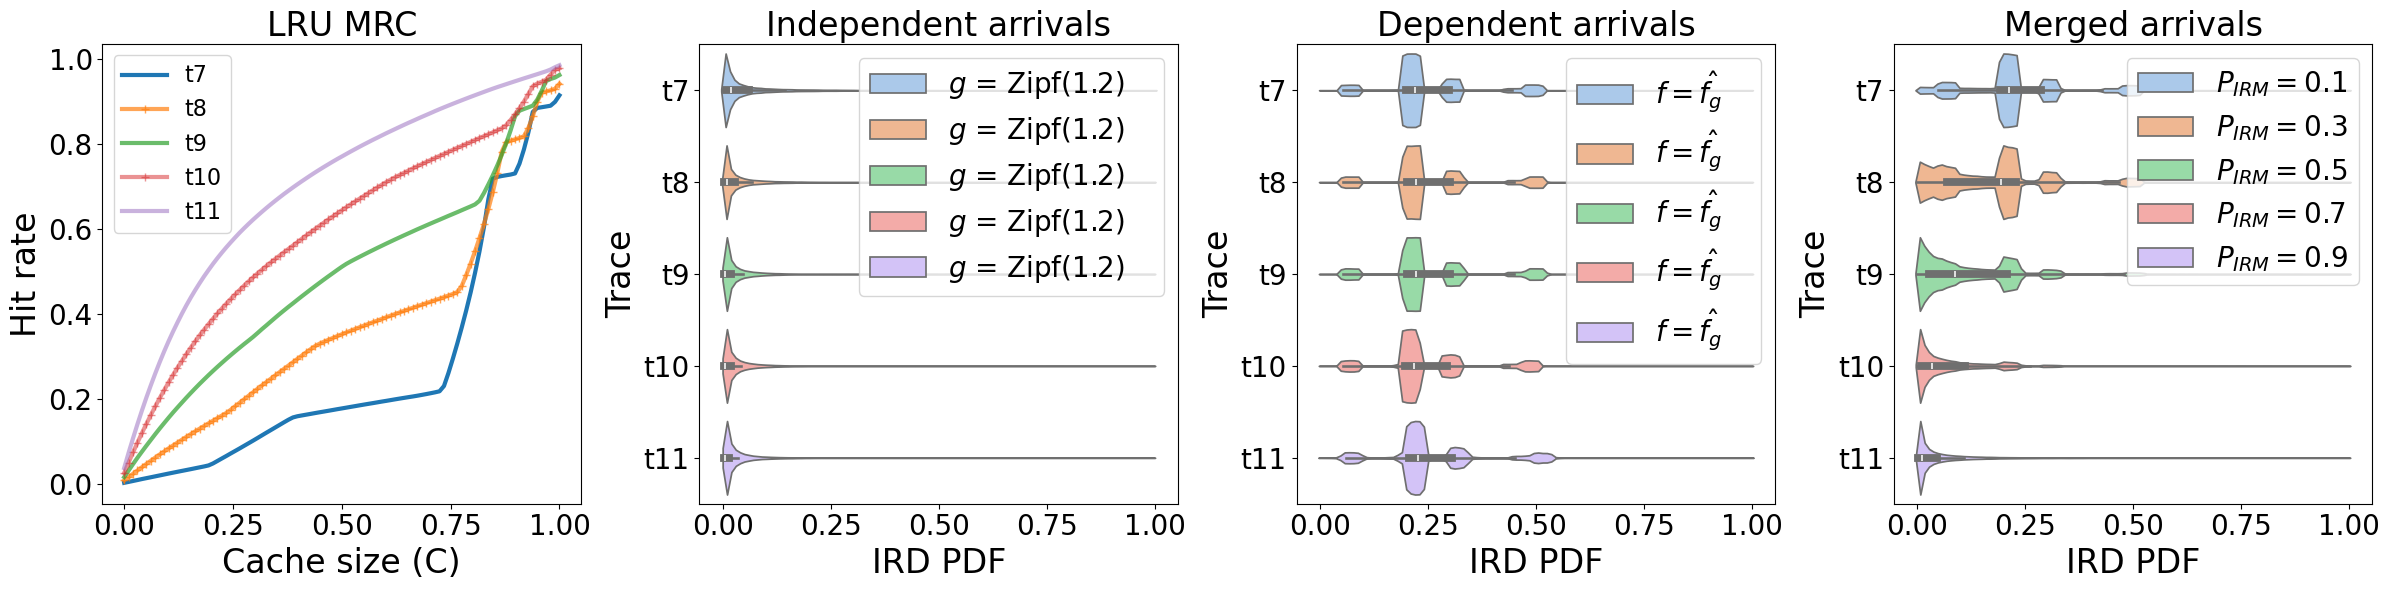

In [55]:
ird_separate_plots([t7, t8, t9, t10, t11], [i7, i8, i9, i10, i11], [c7, c8, c9, c10, c11], [hr7, hr8, hr9, hr10, hr11])

IRM: 900215, IRD: 99785
IRM: 899816, IRD: 100184
IRM: 900477, IRD: 99523


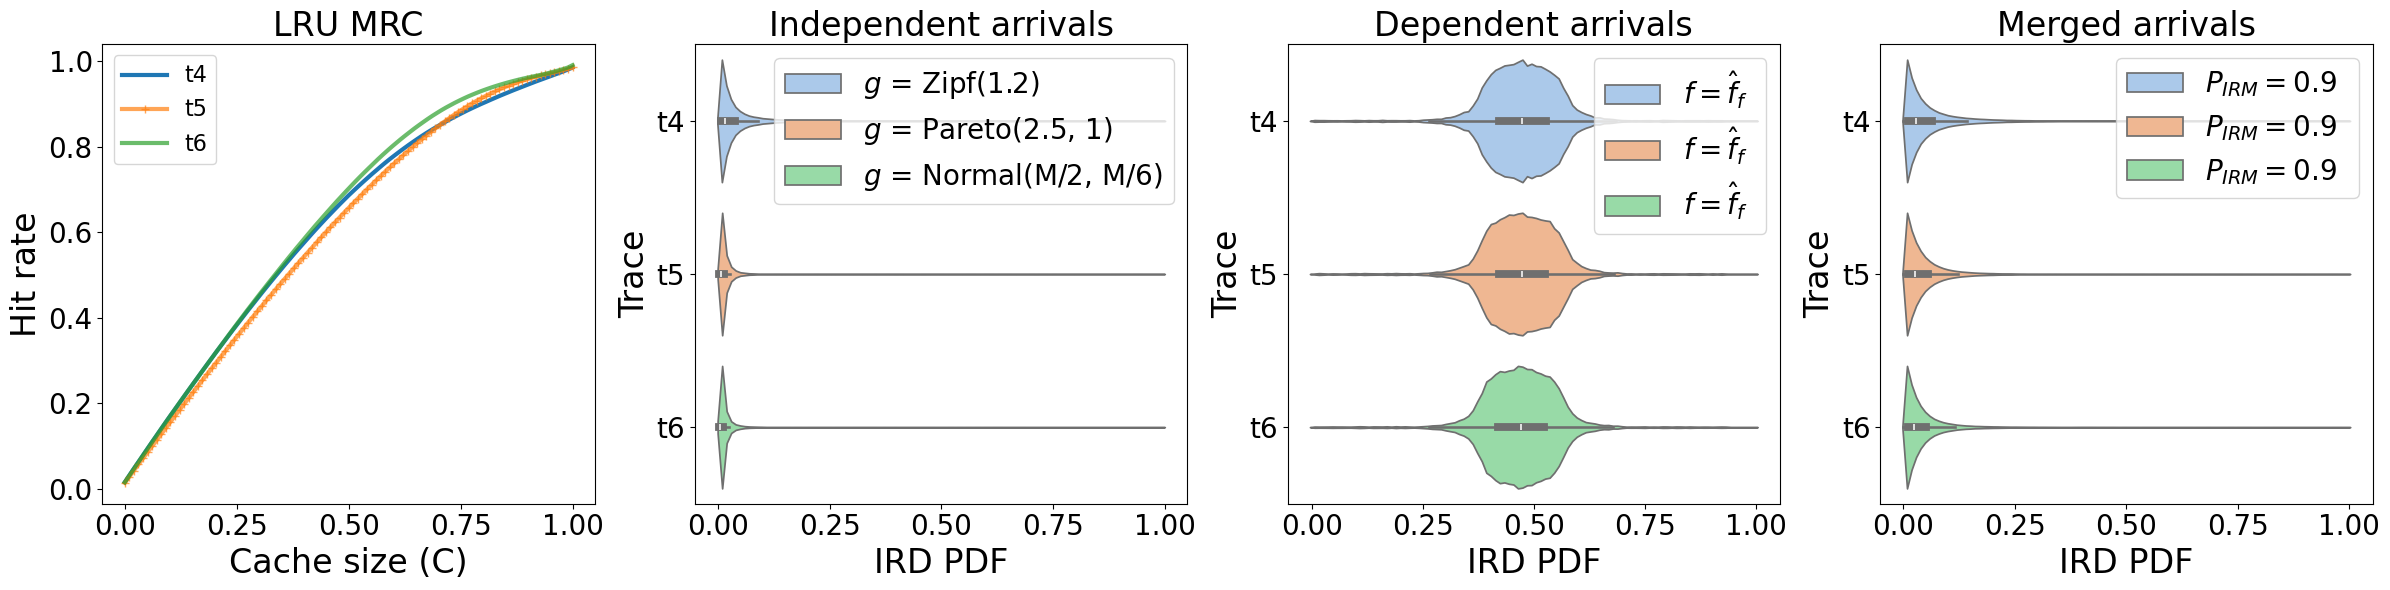

In [53]:
ird_separate_plots([t4, t5, t6], [i4, i5, i6], [c4, c5, c6], [hr4, hr5, hr6])

IRM: 100132, IRD: 899868
IRM: 100023, IRD: 899977
IRM: 100134, IRD: 899866
IRM: 99746, IRD: 900254


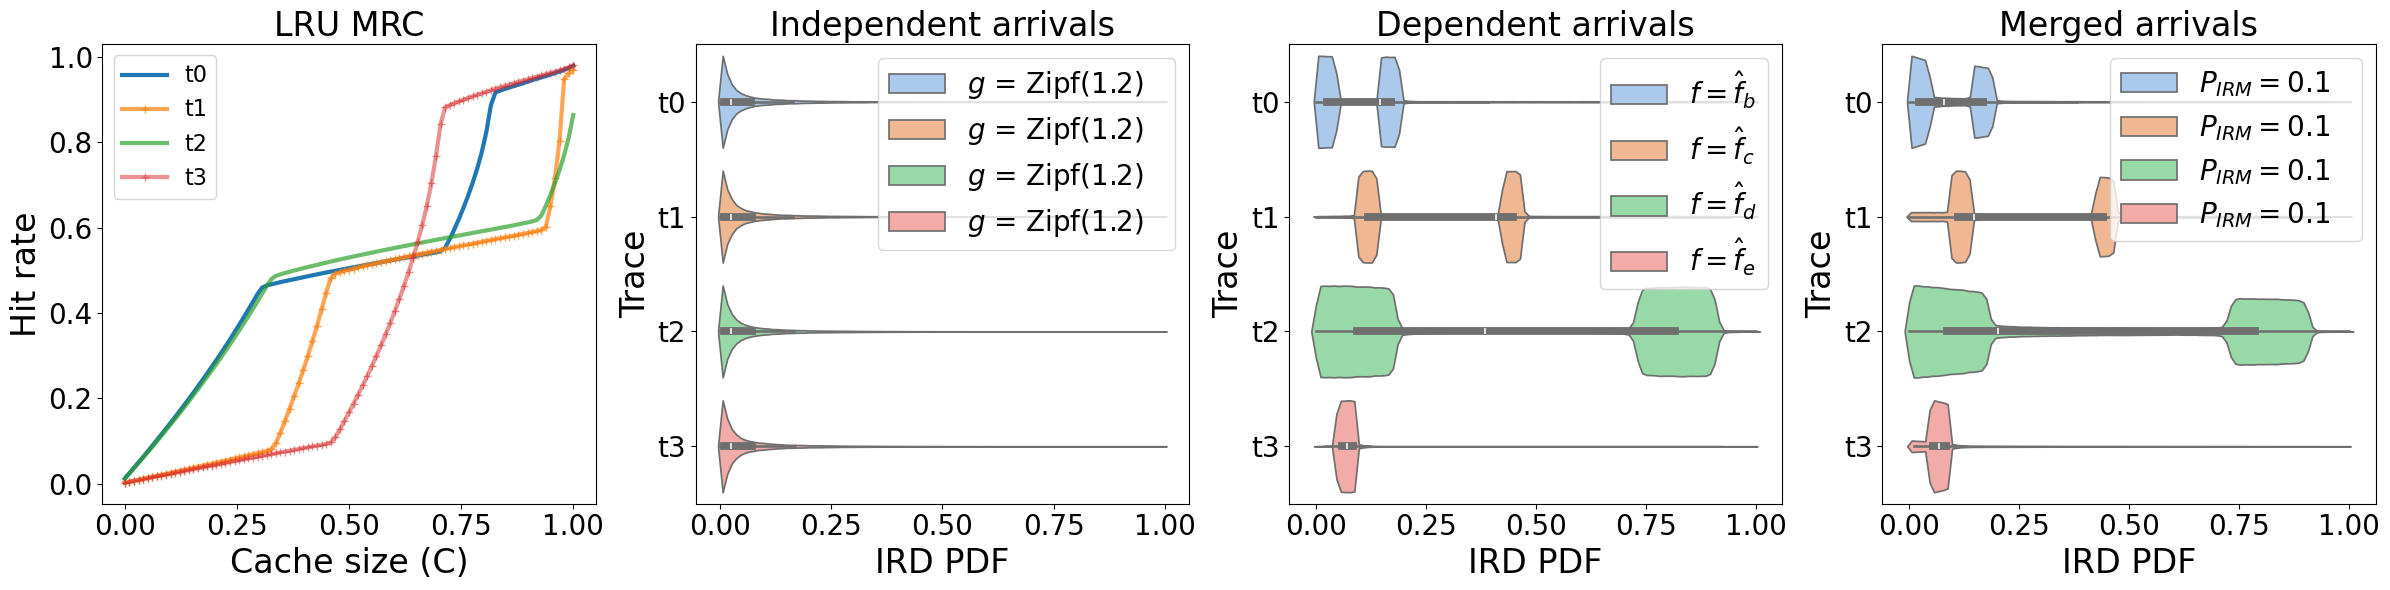

In [51]:
ird_separate_plots([t0, t1, t2, t3], [i0, i1, i2, i3], [c0, c1, c2, c3], [hr0, hr1, hr2, hr3])